IMPORTS

In [1]:
# Connect with drive
from google.colab import drive

drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
# Import and download necessary language models
!pip install tf-nightly
from gensim.models.doc2vec import Doc2Vec, TaggedDocument
from nltk.tokenize import sent_tokenize, word_tokenize
import nltk
import tensorflow as tf
import pickle
import numpy as np
import re
nltk.download('punkt')
nltk.download("stopwords")

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [3]:
#Setting the seeds
lucky_number = 42
np.random.seed(lucky_number)
tf.random.set_seed(lucky_number)

DATA & PREPROCESSING

In [4]:
# Read the data

with open("/content/drive/MyDrive/NLP/wiki_00.txt", "r") as f:
  text = f.readlines()
  text = "".join(text)

# Preprocessing
# Remove the html tags
text = re.sub("<doc.*>", "", text)
text = re.sub("</doc>", "", text)
# Tag the paragraphs, in order to create Y labels later
text = re.sub("\n\n(\n)+", "\n\n", text)
text = re.sub("\n\n", "<p>. ", text)
text[5000:6000]

' olmuştu. Yesügey iki kardeşini yanına alarak ve birlikte ağır ağır giden düğün arabasına yetiştiler. Üç kardeş Onggirat boyunun Olkunat kabilesinden olan Höelin adındaki yeni evli gelini yakaladılar. Höelin başke seçme şansı olmadığı için Yesügey Bahadır’ı yeni kocası olarak kabullendi. Yesügey onunla, doğurduğu oğlan bir kahraman olacak diyerek evlenmişti.<p>. Evlilikten bir süre sonra Yesügey, Tatarlar üzerine yaptığı bir akından geri döndüğünde, Höelin kocasını hamile olduğu haberiyle karşıladı. Kaynaklarda bebeğin doğumu sırasında Höelin’in kapısına bir yay ve ok asılarak şeytanın girmesinin engellendiği ancak yakın akrabalar ve bir kadın Şamanın ebe olarak görev yaptığı ileri sürülmektedir. Şaman, bebeği çok yakından inceleyerek, geleceği hakkında kehanette bulunabilecek bir işaret arayacaktı. Efsaneye göre sağ avucunun içinde sonraları gayet doğal olarak, gücün ve çok kan dökeceğinin simgesi olarak nitelendirilecek aşık kemiği şeklinde bir kan pıhtısı ile doğdu. Yegüsey Bahadır

In [5]:
# Split the text into sentences
text_sent_tokenized = sent_tokenize(text)
text_sent_tokenized[:10]

['\nCengiz Han<p>.',
 'Cengiz Han ("Cenghis Khan", "Çinggis Haan" ya da doğum adıyla Temuçin (anlamı: demirci), Moğolca: "Чингис Хаан" ya da "Tengiz" (anlamı: deniz), ; d. 1162 – ö.',
 "18 Ağustos 1227), Moğol komutan, hükümdar ve Moğol İmparatorluğu'nun kurucusudur.",
 'Cengiz Han, 13.',
 'Yüzyılın başında Orta Asya\'daki tüm göçebe bozkır kavimlerini birleştirerek bir ulus haline getirdi ve o ulusu "Moğol" siyasi kimliği çatısı altında topladı.',
 "Dünya tarihinin en büyük askeri dehalarından biri olarak kabul edilen Cengiz Han, hükümdarlığı döneminde 1206-1227 arasında Kuzey Çin'deki Batı Xia ve Jin Hanedanı, Türkistan'daki Kara Hıtay, Maveraünnehir, Harezm, Horasan ve İran'daki Harzemşahlar ile Kafkasya'da Gürcüler, Deşt-i Kıpçak'taki Rus Knezlikleri ve Kıpçaklar ile İdil Bulgarları üzerine gerçekleştirilen seferler sonucunda Pasifik Okyanusu'ndan Hazar Denizi’ne ve Karadeniz'in kuzeyine kadar uzanan bir imparatorluk kurdu.<p>.",
 'Bozkır geleneğinden gelen onlu teşkilatı kullanara

In [6]:
# Creating the Y labels by utilizing the paragraph tags (<p>.)
# And removing the paragraph tags to obtain the original sentences back again
Y = []
for i in range(len(text_sent_tokenized)):
  if "<p>." in text_sent_tokenized[i]:
    text_sent_tokenized[i] = text_sent_tokenized[i][:-4]
    Y.append(1)
  else:
    Y.append(0)

In [7]:
# Further preprocessing...
for i in range(len(text_sent_tokenized)):
  # Convert to all lowercase
  text_sent_tokenized[i] = text_sent_tokenized[i].lower()
  # Removing punctuation
  text_sent_tokenized[i] = re.sub('[^\w\s]', '', text_sent_tokenized[i])

In [8]:
# Splitting the data
sentence_embedding_train_set_size = 100000
split_boundaries = [int(.8*(len(text_sent_tokenized)-sentence_embedding_train_set_size)), int(.9*(len(text_sent_tokenized)-sentence_embedding_train_set_size)), len(text_sent_tokenized)-sentence_embedding_train_set_size]

train_X_sentences = text_sent_tokenized[:split_boundaries[0]]
validation_X_sentences = text_sent_tokenized[split_boundaries[0]:split_boundaries[1]]
test_X_sentences = text_sent_tokenized[split_boundaries[1]:split_boundaries[2]]

train_Y = Y[:split_boundaries[0]]
validation_Y = Y[split_boundaries[0]:split_boundaries[1]]
test_Y = Y[split_boundaries[1]:split_boundaries[2]]

sentence_embedding_train_set = text_sent_tokenized[split_boundaries[2]:]

SENTENCE EMBEDDING

In [4]:
# Setting the size of the embedding vector
embedding_size = 64

In [10]:
tagged_data = [TaggedDocument(word_tokenize(d), [i]) for i, d in enumerate(sentence_embedding_train_set)]
tagged_data[:3]

[TaggedDocument(words=['wu', 'kuramsal', 'fizikçiler', 'olan', 'tsungdao', 'lee', 've', 'chenning', 'yangın', '1957', 'yıında', 'nobel', 'kazandıkları', 'kuramlarını', 'yapmalarına', 'olanak', 'sağlayan', 'bir', 'deney', 'dizayn', 'etti', 'wu', 'deneyi'], tags=[0]),
 TaggedDocument(words=['tarihçilerin', 'büyük', 'bilim', 'olarak', 'adlandırdıkları', '1930larda', 'ernest', 'o', 'lawrence', 'tarafından', 'siklotronun', 'keşfi', 'ile', 'başlamış', 'olan', 've', 'savaş', 'sonrası', 'dönemi', 'fizikçilerinin', 'teorilerini', 'test', 'etmek', 've', 'yeni', 'sınırlara', 'girmek', 'için', 'devasa', 'makineler', 'bütçeler', 've', 'laboratuvarlar', 'gerektiren', 'bir', 'döneme', 'girildi'], tags=[1]),
 TaggedDocument(words=['fizikte', 'asıl', 'müşterisi', 'hükümetler', 'olmuş', 've', 'temel', 'araştırmaların', 'desteklenmesinin', 'askeri', 've', 'endüstriyel', 'uygulamalar', 'için', 'faydalı', 'teknolojilere', 'neden', 'olabileceğini', 'kabul', 'etmiştir'], tags=[2])]

In [5]:
### IF
# Read the doc2vec model if already written before
# Load the doc2vec model
doc2vec_model = None
with open('/content/drive/MyDrive/NLP/doc2vec.pkl', 'rb') as f:
  doc2vec_model = pickle.load(f)

In [11]:
### ELSE
# DOC2VEC MODEL
doc2vec_model = Doc2Vec(vector_size=embedding_size, min_count=3, epochs=40)
doc2vec_model.build_vocab(tagged_data)
doc2vec_model.train(tagged_data, total_examples=doc2vec_model.corpus_count, epochs=doc2vec_model.epochs)

# Saving the doc2vec model
with open('/content/drive/MyDrive/NLP/doc2vec.pkl', 'wb') as f:
  pickle.dump(doc2vec_model, f)

In [6]:
### IF
# Read the embedding data if already written before
train_X = []
validation_X = []
test_X = []
with open('/content/drive/MyDrive/NLP/train_X.pkl', 'rb') as f:
  train_X = pickle.load(f)
with open('/content/drive/MyDrive/NLP/validation_X.pkl', 'rb') as f:
  validation_X = pickle.load(f)
with open('/content/drive/MyDrive/NLP/test_X.pkl', 'rb') as f:
  test_X = pickle.load(f)

train_Y = []
validation_Y = []
test_Y = []
with open('/content/drive/MyDrive/NLP/train_Y.pkl', 'rb') as f:
  train_Y = pickle.load(f)
with open('/content/drive/MyDrive/NLP/validation_Y.pkl', 'rb') as f:
  validation_Y = pickle.load(f)
with open('/content/drive/MyDrive/NLP/test_Y.pkl', 'rb') as f:
  test_Y = pickle.load(f)

In [ ]:
### ELSE
# Using the embeddings of the sentences and creating the train, validation and test data of X
train_X = []
validation_X = []
test_X = []

from tqdm.notebook import tqdm

for i in tqdm(range(len(train_X_sentences))):
  train_X.append(doc2vec_model.infer_vector(word_tokenize(train_X_sentences[i])))
for i in range(len(validation_X_sentences)):
  validation_X.append(doc2vec_model.infer_vector(word_tokenize(validation_X_sentences[i])))
for i in range(len(test_X_sentences)):
  test_X.append(doc2vec_model.infer_vector(word_tokenize(test_X_sentences[i])))

  0%|          | 0/3231519 [00:00<?, ?it/s]

In [ ]:
### ELSE CONT.
# Write the founded embedding dataset so that you can use it later
with open('/content/drive/MyDrive/NLP/train_X.pkl', 'wb') as f:
  pickle.dump(train_X, f)

with open('/content/drive/MyDrive/NLP/validation_X.pkl', 'wb') as f:
  pickle.dump(validation_X, f)
  
with open('/content/drive/MyDrive/NLP/test_X.pkl', 'wb') as f:
  pickle.dump(test_X, f)

with open('/content/drive/MyDrive/NLP/train_Y.pkl', 'wb') as f:
  pickle.dump(train_Y, f)

with open('/content/drive/MyDrive/NLP/validation_Y.pkl', 'wb') as f:
  pickle.dump(validation_Y, f)
  
with open('/content/drive/MyDrive/NLP/test_Y.pkl', 'wb') as f:
  pickle.dump(test_Y, f)

In [7]:
# Creating bi-gram (sentence-wise) data for model 0
train_X_bi = []
validation_X_bi = []
test_X_bi = []
for i in range(len(train_X)-1):
  train_X_bi.append(np.concatenate((train_X[i], train_X[i+1])))
for i in range(len(validation_X)-1):
  validation_X_bi.append(np.concatenate((validation_X[i], validation_X[i+1])))
for i in range(len(test_X)-1):
  test_X_bi.append(np.concatenate((test_X[i], test_X[i+1])))

train_Y_bi = train_Y[:-1]
validation_Y_bi = validation_Y[:-1]
test_Y_bi = test_Y[:-1]

In [8]:
# Converting the bi's to numpy arrays (only for model 0)
train_X_bi = np.array(train_X_bi, dtype=np.float32)
validation_X_bi = np.array(validation_X_bi, dtype=np.float32)
test_X_bi = np.array(test_X_bi, dtype=np.float32)

train_Y_bi = np.array(train_Y_bi, dtype=np.float32)
validation_Y_bi = np.array(validation_Y_bi, dtype=np.float32)
test_Y_bi = np.array(test_Y_bi, dtype=np.float32)

In [7]:
# Converting the lists to numpy arrays (only for model 1)
train_X = np.array(train_X, dtype=np.float32)
validation_X = np.array(validation_X, dtype=np.float32)
test_X = np.array(test_X, dtype=np.float32)

train_Y = np.array(train_Y, dtype=np.float32)
validation_Y = np.array(validation_Y, dtype=np.float32)
test_Y = np.array(test_Y, dtype=np.float32)

In [8]:
# Converting the inputs to wanted format (only for model 1)
train_X_temp = np.zeros((train_X.shape[0], 1, train_X.shape[1]))
for i in range(train_X.shape[0]):
  train_X_temp[i] = [train_X[i]]
train_X = train_X_temp

validation_X_temp = np.zeros((validation_X.shape[0], 1, validation_X.shape[1]))
for i in range(validation_X.shape[0]):
  validation_X_temp[i] = [validation_X[i]]
validation_X = validation_X_temp

test_X_temp = np.zeros((test_X.shape[0], 1, test_X.shape[1]))
for i in range(test_X.shape[0]):
  test_X_temp[i] = [test_X[i]]
test_X = test_X_temp

In [9]:
# The Model
MODEL_NO = 1

if MODEL_NO == 0: # Simple Dense Model
  model = tf.keras.models.Sequential([
      tf.keras.layers.InputLayer(input_shape=(embedding_size*2,)),
      tf.keras.layers.Dense(10, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dropout(0.5),
      tf.keras.layers.Dense(4, activation='relu'),
      tf.keras.layers.BatchNormalization(),
      tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-1)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.F1Score(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  history = model.fit(x=train_X_bi, y=train_Y_bi, batch_size=64, epochs=7, validation_data=(validation_X_bi, validation_Y_bi), verbose=1)

elif MODEL_NO == 1: # Recurrent model # This enables the model to look further past than only 2 sentences
  model = tf.keras.models.Sequential([
    tf.keras.layers.InputLayer(input_shape=(1,embedding_size)),
    tf.keras.layers.GRU(16, return_sequences=True),
    tf.keras.layers.GRU(16),
    tf.keras.layers.Dense(10, activation='relu'),
    tf.keras.layers.Dense(4, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
  ])
  optimizer = tf.keras.optimizers.Adam(learning_rate=3e-3)
  model.summary()
  model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy',tf.keras.metrics.F1Score(), tf.keras.metrics.Precision(), tf.keras.metrics.Recall()])
  history = model.fit(x=train_X, y=train_Y, batch_size=64, epochs=5, validation_data=(validation_X, validation_Y), verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru (GRU)                   (None, 1, 16)             3936      
                                                                 
 gru_1 (GRU)                 (None, 16)                1632      
                                                                 
 dense (Dense)               (None, 10)                170       
                                                                 
 dense_1 (Dense)             (None, 4)                 44        
                                                                 
 dense_2 (Dense)             (None, 1)                 5         
                                                                 
Total params: 5787 (22.61 KB)
Trainable params: 5787 (22.61 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________
Epoch 1/5
50493/50493 

In [10]:
# Saving the model
model.save('/content/drive/MyDrive/NLP/nlp_' + str(MODEL_NO) + '_type_model')

In [11]:
# Evaluate model
print("EVALUATION ON TEST DATA")
test_loss, test_acc, f1_score, precision, recall = None, None, None, None, None
if MODEL_NO == 0:
  test_loss, test_acc, f1_score, precision, recall = model.evaluate(test_X_bi, test_Y_bi)
if MODEL_NO == 1:
  test_loss, test_acc, f1_score, precision, recall = model.evaluate(test_X, test_Y)

EVALUATION ON TEST DATA
12624/12624 [==============================] - 65s 5ms/step - loss: 0.6273 - accuracy: 0.6650 - f1_score: 0.5648 - precision: 0.6850 - recall: 0.2754


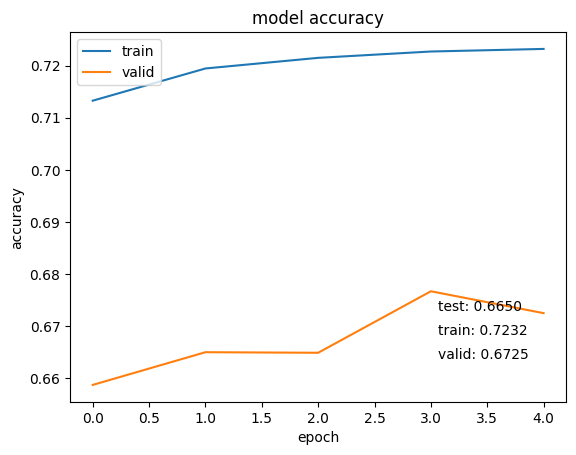

In [12]:
# Plot!
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.figtext(.7, .25, "train: {:.4f}".format(history.history['accuracy'][-1]))
plt.figtext(.7, .2, "valid: {:.4f}".format(history.history['val_accuracy'][-1]))
plt.figtext(.7, .3, "test: {:.4f}".format(test_acc))
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [13]:
# INFERENCE - Prediction function for any given instance
def infer(text_str, mdl): # Build for model type 1
  # Tokenize the text into sentences
  text_sent_tokenized = sent_tokenize(text_str)

  # Prepare the input X
  X = []
  # For all sentences:
  for i in range(len(text_sent_tokenized)):
    # Convert to all lowercase
    text_sent_tokenized[i] = text_sent_tokenized[i].lower()
    # Remove punctuation
    text_sent_tokenized[i] = re.sub('[^\w\s]', '', text_sent_tokenized[i])
    # Create the sentence embedding and add it to X
    X.append(doc2vec_model.infer_vector(word_tokenize(text_sent_tokenized[i])))
  
  # Convert X to a numpy array
  X = np.array(X, dtype=np.float32)

  # Convert X to the expected format (matrix to tensor)
  X_temp = np.zeros((X.shape[0], 1, X.shape[1]))
  for i in range(X.shape[0]):
    X_temp[i] = [X[i]]
  X = X_temp
  
  # Give X to the model in order to obtain the list of labels (Y)
  Y = mdl.predict(X)

  # Construct the paragraph-separated text result
  result_str = ''
  text_sent_tokenized = sent_tokenize(text_str)
  for i in range(Y.shape[0]):
    result_str += text_sent_tokenized[i]
    if Y[i][0] > 0.5:
      result_str += '\n\n' # Paragraph Break

  return Y, result_str

In [14]:
# INFERENCE (PREDICTION)
# (Input has no paragprah breaks)
paragraph_break_probabilities, resulting_text = infer("Dasani, The Coca-Cola Company tarafından üretilen, saflaştırılmamış ve aromalı sudan oluşan şişelenmiş su ürünleri markasıdır. Aquafina'nın başarısından sonra (Coca-Cola'nın rakibi PepsiCo tarafından üretilir) 1999 yılında tanıtıltı. Dünya çapında satılan Coca-Cola şişelenmiş suyun birçok markasından biridir. Ürün musluk suyu, filtrelenmiş ve şişelenmiş formada satılıyor. Coca-Cola, yerel belediye su kaynaklarından musluk suyu kullanır, ters osmoz işlemini kullanarak filtreler ve magnezyum sülfat (Epsom tuzu), potasyum klorür ve sofra tuzu (sodyum klorür dahil) eser miktarda mineral ekler. Coca-Cola, Dasani suyunu% 30 bitki bazlı malzemelerden yapılan yeni ambalajlara dağıtacağını açıkladı. Diğer bitki bazlı ambalajların aksine, şişeler standart geri dönüşüm tesisleriyle uyumludur ve standart su şişelerine kıyasla karbon emisyonlarında% 25'e varan bir düşüşü temsil eder, ancak bu yine de musluk suyunun enerji kullanımının 2000 katını temsil eder. Dasani, Kanada’nın tüm eyaletlerinde, 2000’de Québec’in dışında, Amerika’dan bir yıl sonra lansman yapıldı. Marka, Nisan 2001'de kısa bir süre sonra Quebec'te kullanıma sunuldu. Kanada'daki Dasani suyunun ilk kaynağı Calgary, Alberta idi. İkinci bir şişeleme tesisi daha sonra Brampton, Ontario'da açıldı. Calgary ve Brampton tesisleri Coca-Cola'nın düz su (Dasani) ve şekerli su (meşrubat) ürünlerini üretmektedir. Şirketin idari ve pazarlama faaliyetleri Atlanta, Georgia şehrindedir. Dasani <35 ppm toplam çözünmüş mineral tuzuna sahiptir. 2005 yılının başında, Dasani'nin iki aromalı versiyonu tanıtıldı: Ahududu ile Limon. Çilekli Dasani o zamandan beri tanıtıldı. Aromalı içecekler sukraloz ile tatlandırılır. Dasani, 2003 ortalarında Brezilya piyasasına Kova adıyla tanıtıldı. Düzenli, limon ve mandalina lezzetleri de dahil olmak üzere 2005 yılında Şili pazarına sunuldu. 2005'in sonlarında Kolombiya'da üç düzenli lezzeti ile serbest bırakıldı. 2005 yılında Dasani, Arjantin pazarında şeftali, limon, narenciye ve düzenli tatlarla tanıtıldı. Aynı zamanda Meksika'da Ciel Dasani adı altında dört lezzet olarak piyasaya sürüldü. Ayrıca Peru, Ekvador, Paraguay, Uruguay ve Hondurasda da sunuldu.", model)

1/1 [==============================] - 1s 1s/step


In [15]:
paragraph_break_probabilities

array([[0.2983348 ],
       [0.2493147 ],
       [0.32172167],
       [0.35217863],
       [0.39247873],
       [0.33069974],
       [0.32077903],
       [0.3470442 ],
       [0.3202742 ],
       [0.53133476],
       [0.22475606],
       [0.3650225 ],
       [0.37736073],
       [0.31540108],
       [0.04532127],
       [0.34910408],
       [0.44125494],
       [0.3097947 ],
       [0.35980174],
       [0.17633699],
       [0.34156144],
       [0.3408305 ],
       [0.3826427 ]], dtype=float32)

The input was:

Dasani, The Coca-Cola Company tarafından üretilen, saflaştırılmamış ve aromalı sudan oluşan şişelenmiş su ürünleri markasıdır. Aquafina'nın başarısından sonra (Coca-Cola'nın rakibi PepsiCo tarafından üretilir) 1999 yılında tanıtıltı. Dünya çapında satılan Coca-Cola şişelenmiş suyun birçok markasından biridir. Ürün musluk suyu, filtrelenmiş ve şişelenmiş formada satılıyor. Coca-Cola, yerel belediye su kaynaklarından musluk suyu kullanır, ters osmoz işlemini kullanarak filtreler ve magnezyum sülfat (Epsom tuzu), potasyum klorür ve sofra tuzu (sodyum klorür dahil) eser miktarda mineral ekler. Coca-Cola, Dasani suyunu% 30 bitki bazlı malzemelerden yapılan yeni ambalajlara dağıtacağını açıkladı. Diğer bitki bazlı ambalajların aksine, şişeler standart geri dönüşüm tesisleriyle uyumludur ve standart su şişelerine kıyasla karbon emisyonlarında% 25'e varan bir düşüşü temsil eder, ancak bu yine de musluk suyunun enerji kullanımının 2000 katını temsil eder. Dasani, Kanada’nın tüm eyaletlerinde, 2000’de Québec’in dışında, Amerika’dan bir yıl sonra lansman yapıldı. Marka, Nisan 2001'de kısa bir süre sonra Quebec'te kullanıma sunuldu. Kanada'daki Dasani suyunun ilk kaynağı Calgary, Alberta idi. İkinci bir şişeleme tesisi daha sonra Brampton, Ontario'da açıldı. Calgary ve Brampton tesisleri Coca-Cola'nın düz su (Dasani) ve şekerli su (meşrubat) ürünlerini üretmektedir. Şirketin idari ve pazarlama faaliyetleri Atlanta, Georgia şehrindedir. Dasani <35 ppm toplam çözünmüş mineral tuzuna sahiptir. 2005 yılının başında, Dasani'nin iki aromalı versiyonu tanıtıldı: Ahududu ile Limon. Çilekli Dasani o zamandan beri tanıtıldı. Aromalı içecekler sukraloz ile tatlandırılır. Dasani, 2003 ortalarında Brezilya piyasasına Kova adıyla tanıtıldı. Düzenli, limon ve mandalina lezzetleri de dahil olmak üzere 2005 yılında Şili pazarına sunuldu. 2005'in sonlarında Kolombiya'da üç düzenli lezzeti ile serbest bırakıldı. 2005 yılında Dasani, Arjantin pazarında şeftali, limon, narenciye ve düzenli tatlarla tanıtıldı. Aynı zamanda Meksika'da Ciel Dasani adı altında dört lezzet olarak piyasaya sürüldü. Ayrıca Peru, Ekvador, Paraguay, Uruguay ve Hondurasda da sunuldu.

In [16]:
print(resulting_text)
# The output is:

Dasani, The Coca-Cola Company tarafından üretilen, saflaştırılmamış ve aromalı sudan oluşan şişelenmiş su ürünleri markasıdır.Aquafina'nın başarısından sonra (Coca-Cola'nın rakibi PepsiCo tarafından üretilir) 1999 yılında tanıtıltı.Dünya çapında satılan Coca-Cola şişelenmiş suyun birçok markasından biridir.Ürün musluk suyu, filtrelenmiş ve şişelenmiş formada satılıyor.Coca-Cola, yerel belediye su kaynaklarından musluk suyu kullanır, ters osmoz işlemini kullanarak filtreler ve magnezyum sülfat (Epsom tuzu), potasyum klorür ve sofra tuzu (sodyum klorür dahil) eser miktarda mineral ekler.Coca-Cola, Dasani suyunu% 30 bitki bazlı malzemelerden yapılan yeni ambalajlara dağıtacağını açıkladı.Diğer bitki bazlı ambalajların aksine, şişeler standart geri dönüşüm tesisleriyle uyumludur ve standart su şişelerine kıyasla karbon emisyonlarında% 25'e varan bir düşüşü temsil eder, ancak bu yine de musluk suyunun enerji kullanımının 2000 katını temsil eder.Dasani, Kanada’nın tüm eyaletlerinde, 2000’de 